In [21]:
!pip install nba_api pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.endpoints import leaguedashplayerstats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Set visualization style
sns.set(style="whitegrid")
%matplotlib inline


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
def get_nba_data(season='2023-24'):
    print(f"Fetching data for {season} season via NBA API...")
    
    # Fetch Base Stats
    base = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season,
        per_mode_detailed='PerGame',
        season_type_all_star='Regular Season',
        measure_type_detailed_defense='Base'
    ).get_data_frames()[0]

    # Fetch Advanced Stats
    adv = leaguedashplayerstats.LeagueDashPlayerStats(
        season=season,
        per_mode_detailed='PerGame',
        season_type_all_star='Regular Season',
        measure_type_detailed_defense='Advanced'
    ).get_data_frames()[0]
    
    # Merge them
    cols_to_use = ['PLAYER_ID', 'PLAYER_NAME', 'OFF_RATING', 'DEF_RATING', 
                   'NET_RATING', 'TS_PCT', 'USG_PCT', 'AST_PCT', 'REB_PCT']
    full_df = pd.merge(base, adv[cols_to_use], on=['PLAYER_ID', 'PLAYER_NAME'], how='left')
    return full_df

# Get the data
df = get_nba_data()

# Filter low minutes
df['MIN'] = df['MIN'].astype(float)
df_filtered = df[df['MIN'] > 15].reset_index(drop=True)
print(f"Data Loaded. Players: {len(df_filtered)}")

Fetching data for 2023-24 season via NBA API...
Data Loaded. Players: 336


In [23]:
features = [
    'PTS', 'REB', 'AST', 'STL', 'BLK', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 
    'USG_PCT', 'TS_PCT', 'AST_PCT', 'FG3A', 'FTA'
]
X = df_filtered[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_df['Player'] = df_filtered['PLAYER_NAME']

# K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(X_scaled)
df_filtered['Cluster'] = pca_df['Cluster']

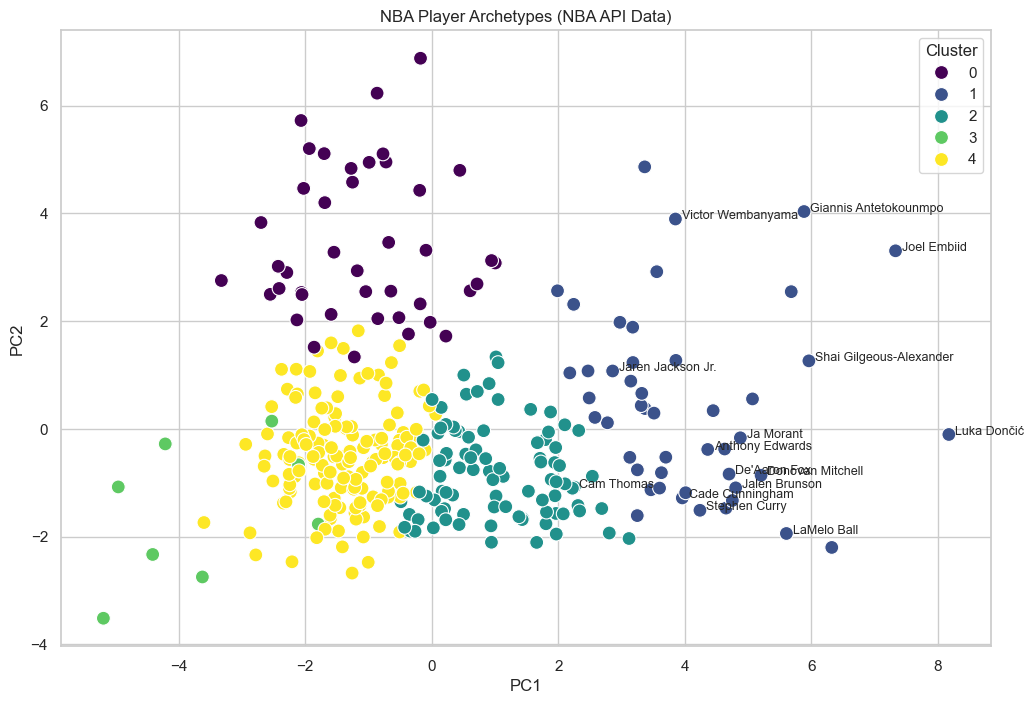

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)

# Annotate a few famous players
stars = df_filtered.nlargest(15, 'USG_PCT')['PLAYER_NAME'].tolist()
for i in range(len(pca_df)):
    if pca_df.Player[i] in stars:
        plt.text(pca_df.PC1[i]+0.1, pca_df.PC2[i], pca_df.Player[i], fontsize=9)

plt.title('NBA Player Archetypes (NBA API Data)')
plt.show()

In [26]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(X_scaled)

# Add numeric IDs to dataframes temporarily
df_filtered['Cluster_ID'] = cluster_ids
pca_df['Cluster_ID'] = cluster_ids

In [27]:
def get_archetype_names(df, cluster_col='Cluster_ID'):
    """
    Analyzes the stats of each numeric cluster to assign a proposal-aligned name.
    """
    # Get averages for the features that distinguish roles
    # USG (Ball dominance), AST (Playmaking), REB/BLK (Bigs), 3PA (Shooting)
    stats = df.groupby(cluster_col)[['USG_PCT', 'AST', 'REB', 'BLK', 'FG3A']].mean()

    mapping = {}
    remaining = list(stats.index)

    # A. RIM PROTECTOR: Highest Combo of Rebounds + Blocks
    stats['Big_Score'] = stats['REB'] + (stats['BLK'] * 1.5)
    rim_id = stats['Big_Score'].idxmax()
    mapping[rim_id] = "Rim Protector"
    remaining.remove(rim_id)

    # B. PRIMARY CREATOR: Highest Assists among the rest
    creator_id = stats.loc[remaining, 'AST'].idxmax()
    mapping[creator_id] = "Primary Creator"
    remaining.remove(creator_id)

    # C. ROLE PLAYER: Lowest Usage among the rest (Bench/Low volume)
    role_id = stats.loc[remaining, 'USG_PCT'].idxmin()
    mapping[role_id] = "Role Player"
    remaining.remove(role_id)

    # D. SHOOTER/FLOOR SPACER: Highest 3-Point Attempts among the rest
    shooter_id = stats.loc[remaining, 'FG3A'].idxmax()
    mapping[shooter_id] = "Floor Spacer"
    remaining.remove(shooter_id)

    # E. VERSATILE FORWARD: The last one left (usually balanced stats)
    if remaining:
        mapping[remaining[0]] = "Versatile Forward"

    return mapping

In [28]:
name_map = get_archetype_names(df_filtered)
df_filtered['Archetype'] = df_filtered['Cluster_ID'].map(name_map)
pca_df['Archetype'] = pca_df['Cluster_ID'].map(name_map)

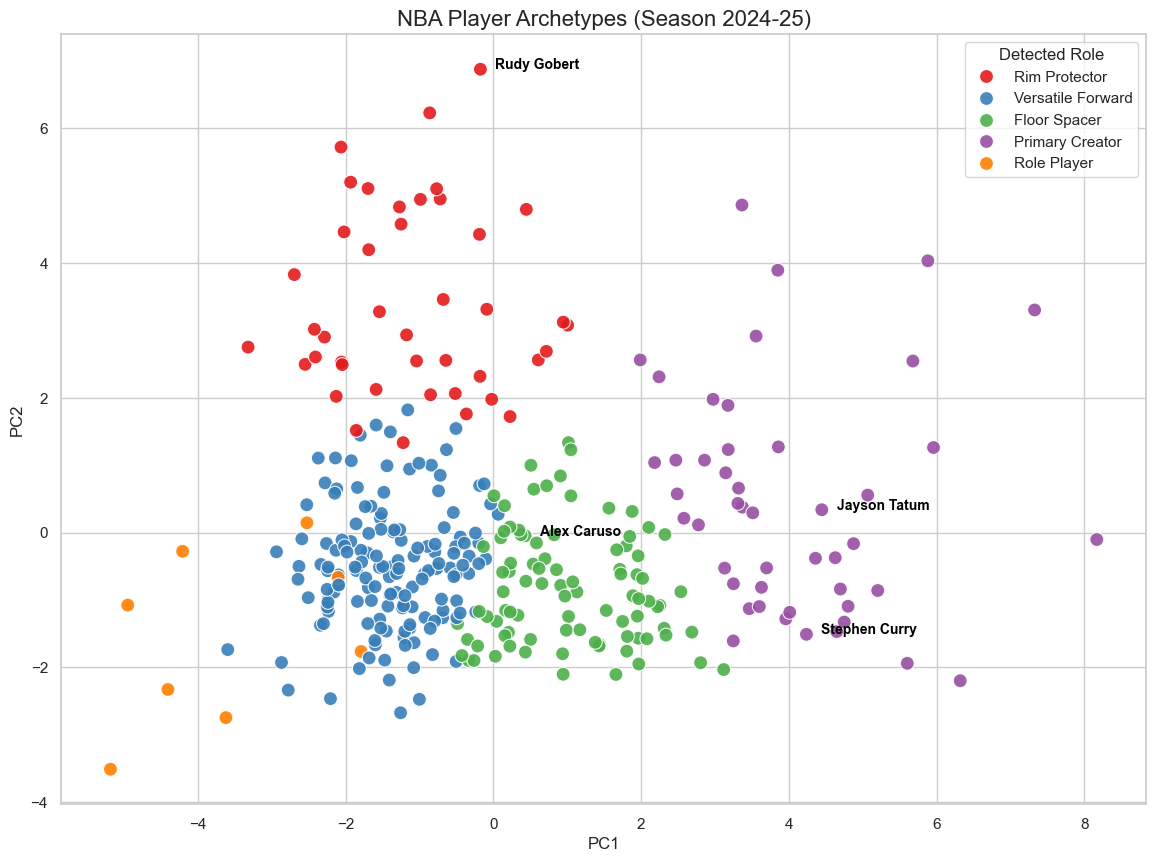

In [29]:
plt.figure(figsize=(14, 10))
# Plot with text labels as the hue/color
sns.scatterplot(x='PC1', y='PC2', hue='Archetype', data=pca_df, palette='Set1', s=100, alpha=0.9)

# Annotate huge stars to check accuracy
stars = ['Nikola Jokic', 'Luka Doncic', 'Stephen Curry', 'Rudy Gobert', 'Jayson Tatum', 'Alex Caruso']
for i in range(len(pca_df)):
    if pca_df.Player[i] in stars:
        # Shift text slightly so it doesn't cover the dot
        plt.text(pca_df.PC1[i]+0.2, pca_df.PC2[i], pca_df.Player[i], fontsize=10, weight='bold', color='black')

plt.title('NBA Player Archetypes (Season 2024-25)', fontsize=16)
plt.legend(title='Detected Role')
plt.show()

In [30]:
print("Average Stats by Archetype:")
summary = df_filtered.groupby('Archetype')[['PTS', 'REB', 'AST', 'FG3A', 'FTA', 'USG_PCT', 'BLK']].mean()
display(summary.style.background_gradient(cmap='coolwarm'))

print("\nExample Players in Each Archetype:")
for role in summary.index:
    players = df_filtered[df_filtered['Archetype'] == role]['PLAYER_NAME'].head(8).tolist()
    print(f"- {role}: {', '.join(players)}")

Average Stats by Archetype:


,PTS,REB,AST,FG3A,FTA,USG_PCT,BLK
Archetype,,,,,,,
Floor Spacer,14.672222,4.161111,3.857778,5.137778,2.526667,0.213433,0.397778
Primary Creator,24.057447,6.623404,5.868085,5.661702,5.785106,0.278574,0.761702
Rim Protector,10.271429,7.585714,1.695238,0.828571,2.297619,0.160643,1.159524
Role Player,3.550000,3.525000,1.425000,1.650000,0.500000,0.133875,0.350000
Versatile Forward,7.958389,3.489933,1.743624,3.138255,1.215436,0.153570,0.404027



Example Players in Each Archetype:
- Floor Spacer: Alex Caruso, Anfernee Simons, Austin Reaves, Bennedict Mathurin, Bogdan Bogdanović, Bojan Bogdanovic, Bradley Beal, Brandon Miller
- Primary Creator: Alperen Sengun, Anthony Davis, Anthony Edwards, Bam Adebayo, Brandon Ingram, Cade Cunningham, Damian Lillard, De'Aaron Fox
- Rim Protector: Aaron Gordon, Amen Thompson, Andre Drummond, Ausar Thompson, Ben Simmons, Bismack Biyombo, Brandon Clarke, Brook Lopez
- Role Player: DeJon Jarreau, Gabe Vincent, Jack White, Kobi Simmons, Malik Williams, Timmy Allen, Wenyen Gabriel, Xavier Tillman
- Versatile Forward: Aaron Holiday, Aaron Nesmith, Aaron Wiggins, Al Horford, Alec Burks, Amir Coffey, Andrew Nembhard, Andrew Wiggins
